# Building Chemical Reaction Networks (CRNs) Directly with BioCRNpyler

**Overview:**  This tutorial shows how to use [BioCRNpyler](https://github.com/BuildACell/BioCRNPyler) to represent simple CRNs

## What is a CRN?
A CRN is a widely established model of chemistry and biochemistry.
* A set of species $S$
* A set of reactions $R$ interconvert species $I_r$ to $O_r$

\begin{align}
\\
I \xrightarrow[]{\rho(s)} O
\\
\end{align}

 * $I$ and $O$ are multisets of species $S$. 
 * $\rho(s): S \to \mathbb{R}$ is a function that determines how fast the reaction occurs.


In [1]:
#Import everything from biocrnpyler
from biocrnpyler import *

## Combining Species and Reactions into a CRN

The following code defines a species called 'S' made out of material 'material'. Species can also have attributes to help identify them. Note that Species with the same name, but different materials or attributes are considered different species in terms of the reactions they participate in.

    S = Species('name', material_type = 'material', attributes = [])

The collowing code produces a reaction R
    
    R = Reaction(Inputs, Outputs, k)

here Inputs and Outputs must both be a list of Species. the parameter k is the rate constant of the reaction. By default, propensities in BioCRNpyler are massaction:

### $\rho(S) = k \Pi_{s} s^{I_s}$

Note: for stochastic models mass action propensities are $\rho(S) = k \Pi_{s} s!/(s - I_s)!$.

Massaction reactions can be made reversible with the k_rev keyword:

    R_reversible = Reaction(Inputs, Outputs, k, k_rev = krev)

is the same as two reactions:

    R = Reaction(Inputs, Outputs, k)
    Rrev = Reaction(Outputs, Inputs, krev)


Finally, a CRN can be made by combining species and reactions:

    CRN = ChemicalReactionNetwork(species = species, reactions = reactions)


In [2]:
#Example: Model the CRN consisting of: A --> 2B, 2B <--> B + C where C has the same name as B but a new material
A = Species("A", material_type = "m1", attributes = ["attribute"])
B = Species("B", material_type = "m1")
C = Species("B", material_type = "m2")
D = Species("D")

print("Species can be printed to show their string representation:", A, B, C, D)

#Reaction Rates
k1 = 3.
k2 = 1.4
k2rev = 0.15

#Reaciton Objects
R1 = Reaction.from_massaction([A], [B, B], k_forward = k1)
R2 = Reaction.from_massaction([B], [C, D], k_forward = k2)

print("\nReactions can be printed as well:\n", R1,"\n", R2)

#Make a CRN
CRN = ChemicalReactionNetwork(species = [A, B, C, D], reactions = [R1, R2])

#CRNs can be printed in two different ways
print("\nDirectly printing a CRN shows the string representation of the species used in BioCRNpyler:")
print(CRN)

print("\nCRN.pretty_print(...) is a function that prints a more customizable version of the CRN, but doesn't show the proper string representation of species.")
print(CRN.pretty_print(show_materials = True, show_rates = True, show_attributes = True))

Species can be printed to show their string representation: m1_A_attribute m1_B m2_B D

Reactions can be printed as well:
 m1[A(attribute)] --> 2m1[B] 
 m1[B] --> m2[B]+D

Directly printing a CRN shows the string representation of the species used in BioCRNpyler:
Species = m1_A_attribute, m1_B, m2_B, D
Reactions = [
	m1[A(attribute)] --> 2m1[B]
	m1[B] --> m2[B]+D
]

CRN.pretty_print(...) is a function that prints a more customizable version of the CRN, but doesn't show the proper string representation of species.
Species (4) = {0. m1[A(attribute)], 1. m1[B], 2. m2[B], 3. D}

Reactions (2) = [
0. m1[A(attribute)] --> 2m1[B]
 Kf=k_forward * m1_A_attribute
  k_forward=3.0

1. m1[B] --> m2[B]+D
 Kf=k_forward * m1_B
  k_forward=1.4

]


## CRNs can be saved as SBML and simulated

To save a CRN as SBML:

    CRN.write_sbml_file("file_name.xml")

To simulate a CRN with biosrape:

    Results, Model = CRN_expression.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)

Where x0 is a dictionary: x0 = {str(species_name):initial_value}

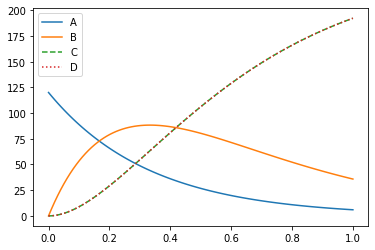

In [3]:
#Saving and simulating a CRN
CRN.write_sbml_file("build_crns_directly.xml")


try:
    import bioscrape
    import numpy as np
    import pylab as plt
    import pandas as pd
    
    #Initial conditions can be set with a dictionary:
    x0 = {str(A):120}
    timepoints = np.linspace(0, 1, 100)#Timepoints to simulate over
    
    #This function can also take a filename keyword to save the file at the same time
    R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0)

    #Check to ensure simulation worked
    #Results are in a Pandas Dictionary and can be accessed via string-names of species
    plt.plot(R['time'], R[str(A)], label = "A")
    plt.plot(R['time'], R[str(B)], label = "B")
    plt.plot(R['time'], R[str(C)], "--", label = "C")
    plt.plot(R['time'], R[str(D)],":", label = "D")
    plt.legend()
    
except ModuleNotFoundError:
    print("Plotting Modules not installed.")

## ComplexSpecies and OrderedComplexSpecies

When Species bind together to form complexes, it is recommended to use the Complex function:

    Complex([list of species], ordered = True/False) 

This function returns the classes ComplexSpecies or OrderedComplexSpecies subclasses which contain information about the species inside of them. ComplexSpecies treats its internal species as an unordered multiset. OrderedComplexSpecies treats its internal species as an ordered list. It is recommended to always use the function Complex to create these types of Species for compatability reasons discussed in the OrderedPolymerSpecies example notebook.

_Note: These objects do not automatically generate binding reactions. To do that, use the Component wrappers ChemicalComplex and OrderedChemicalComplex._

In [4]:
A = Species("A", material_type = "m1")
B = Species("B", material_type = "m1")
B2 = Species("B", material_type = "m2")

print("\nFor ComplexSpecies, the order of the elements does not matter:")
C1 = Complex([A, B, B2, A])
C2 = Complex([B, A, B2, A])
print("C1=ComplexSpecies([A, B, B2, A])=", C1)
print("C2=ComplexSpecies([B, A, B2, A])=", C2)
print("C1==C2 ==>", C1==C2)

print("\nFor OrderedComplexSpecies, the Order Does Matter:")
C3 = Complex([A, B, B2, A], ordered = True)
C4 = Complex([B, A, B2, A], ordered = True)
print("C3=OrderedComplexSpecies([A, B, B2, A])=", C3)
print("C4=OrderedComplexSpecies([B, A, B2, A])=", C4)
print("C3==C4 ==>", C3==C4)

print("\nComplexSpecies (and the OrderedComplexSpecies and Multimers) are Species and can be used in reactions:")
R = Reaction.from_massaction([A, B, B2, A], [C1], k_forward=10)
print("Reaction.from_massaction([A, B, B2, A], [C1], k_forward = 10)=")
print(R)


For ComplexSpecies, the order of the elements does not matter:
C1=ComplexSpecies([A, B, B2, A])= complex_m1_A_2x_m1_B_m2_B
C2=ComplexSpecies([B, A, B2, A])= complex_m1_A_2x_m1_B_m2_B
C1==C2 ==> True

For OrderedComplexSpecies, the Order Does Matter:
C3=OrderedComplexSpecies([A, B, B2, A])= ordered_complex_m1_A_m1_B_m2_B_m1_A
C4=OrderedComplexSpecies([B, A, B2, A])= ordered_complex_m1_B_m1_A_m2_B_m1_A
C3==C4 ==> False

ComplexSpecies (and the OrderedComplexSpecies and Multimers) are Species and can be used in reactions:
Reaction.from_massaction([A, B, B2, A], [C1], k_forward = 10)=
2m1[A]+m1[B]+m2[B] --> complex[2x_m1[A]:m1[B]:m2[B]]


## Non-massaction propensities in BioCRNpyler
By default, BioCRNpyler assumes that propensities are massaction with only one parameter, the rate constant $k$. However, non-massaction propensities are also supported. However, additional propensity types are also supported. When creating a reaction with non-massaction propensities, a propensity_params dictionary must be passed into the chemical_reaction_network.reaction constructor with the appropriate parameters for that particular propensity type. The supported propensity types and their relevant parameters are:

1. "massaction": $\rho(S) = k \Pi_{s} s^{I_s}$. Required parameters: "k" the rate constant. Note: for stochastic models mass action propensities are $\rho(S) = k \Pi_{s} s!/(s - I_s)!$.
2. "positivehill": $\rho(s) = k \frac{s^n}{(K^n+s^n)}$. Requried parameters: rate constant "k", offset "K", hill coefficient "n", hill species "s1".
3. "negativehill": $\rho(s) = k \frac{1}{(K^n+s^n)}$. Requried parameters: rate constant "k", offset "K", hill coefficient "n", hill species "s1".
4. "proportionalpositivehill": $\rho(s) = k d \frac{s^n}{(K^n+s^n)}$. Requried parameters: rate constant "k", offset "K", hill coefficient "n", hill species "s1", propritional species "d".
5. "proportionalnegativehill": $\rho(s) = k d \frac{1}{(K^n+s^n)}$. Requried parameters: rate constant "k", offset "K", hill coefficient "n", hill species "s1", propritional species "d".
6. "general": $\rho(s) = f(s)$ where $f$ can be any algebraic function typed as a string. Required parameters: "rate" an algebraic expression including species and model parameters written as a string.

The following notebook contains examples of the propensity types support by BioCRNpyler applied to a very simple model of genetic activation and repression.

In [5]:
from biocrnpyler.chemical_reaction_network import ChemicalReactionNetwork
from biocrnpyler.species import Species
from biocrnpyler.reaction import Reaction


#Parameter Values
kb = 100
ku = 10
kex = 1.
kd = .1

#Species
G = Species(name = "G", material_type = "dna") #DNA
A = Species(name = "A", material_type = "protein") #Activator
GA = Complex([G, A, A]) #Activated Gene
X = Species(name = "X", material_type = "protein")

rxnd = Reaction.from_massaction([X], [], k_forward=kd)

#Massaction Activation
species1 = [G, A, GA, X]
mak = MassAction(k_forward=kb, k_reverse=ku)
rxn0_1 = Reaction([G, A, A], [GA], propensity_type=mak)
rxn0_2 = Reaction.from_massaction([GA], [GA, X], k_forward=kex)
CRN0 = ChemicalReactionNetwork(species1, [rxn0_1, rxn0_2, rxnd])
print("\nMassaction Activation", repr(CRN0))

#Massaction Repression
rxn1_1 = Reaction.from_massaction([G, A, A], [GA], k_forward=kb, k_reverse=ku)
rxn1_2 = Reaction.from_massaction([G], [G, X], k_forward=kex)
CRN1 = ChemicalReactionNetwork(species1, [rxn1_1, rxn1_2, rxnd])
print("\nMassaction Repression", repr(CRN1))

#Hill positive
species2 = [G, A, X]
hill_positive = HillPositive(k=kex, K=float(kb/ku), s1=A, n=2)
rxn2_1 = Reaction([G], [G, X], propensity_type=hill_positive)
CRN2 = ChemicalReactionNetwork(species2, [rxn2_1, rxnd])
print("\nHill Positive CRN", repr(CRN2))

#proportional Hill positive
prop_hill_positive = ProportionalHillPositive(k=kex, K=float(kb/ku), s1=A, d=G, n=2)
rxn3_1 = Reaction([G], [G, X], propensity_type=prop_hill_positive)
CRN3 = ChemicalReactionNetwork(species2, [rxn3_1, rxnd])
print("\nProportional Hill Positive CRN", repr(CRN3))

#Hill Negative
hill_negative = HillNegative(k=kex, K=float(kb/ku), n=2, s1=A)
rxn4_1 = Reaction([G], [G, X], propensity_type=hill_negative)
CRN4 = ChemicalReactionNetwork(species2, [rxn4_1, rxnd])
print("\nHill Negative CRN", repr(CRN4))

#proportional hill negative
prop_hill_negative = ProportionalHillNegative(k=kex, K=float(kb/ku), s1=A, d=G, n=2)
rxn5_1 = Reaction([G], [G, X], propensity_type=prop_hill_negative)
CRN5 = ChemicalReactionNetwork(species2, [rxn5_1, rxnd])
print("\nProportional Hill Negative CRN", repr(CRN5))


Massaction Activation Species = dna_G, protein_A, complex_dna_G_protein_A_2x, protein_X
Reactions = [
	dna[G]+2protein[A] <--> complex[dna[G]:2x_protein[A]]
	complex[dna[G]:2x_protein[A]] --> complex[dna[G]:2x_protein[A]]+protein[X]
	protein[X] --> 
]

Massaction Repression Species = dna_G, protein_A, complex_dna_G_protein_A_2x, protein_X
Reactions = [
	dna[G]+2protein[A] <--> complex[dna[G]:2x_protein[A]]
	dna[G] --> dna[G]+protein[X]
	protein[X] --> 
]

Hill Positive CRN Species = dna_G, protein_A, protein_X
Reactions = [
	dna[G] --> dna[G]+protein[X]
	protein[X] --> 
]

Proportional Hill Positive CRN Species = dna_G, protein_A, protein_X
Reactions = [
	dna[G] --> dna[G]+protein[X]
	protein[X] --> 
]

Hill Negative CRN Species = dna_G, protein_A, protein_X
Reactions = [
	dna[G] --> dna[G]+protein[X]
	protein[X] --> 
]

Proportional Hill Negative CRN Species = dna_G, protein_A, protein_X
Reactions = [
	dna[G] --> dna[G]+protein[X]
	protein[X] --> 
]


In [8]:
CRN1.write_sbml_file('crn1.xml')
CRN2.write_sbml_file('crn2.xml')
CRN3.write_sbml_file('crn3.xml')
CRN4.write_sbml_file('crn4.xml')
CRN5.write_sbml_file('crn5.xml')

True